<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E5%8D%97%E4%BA%9EPA%E5%BB%A0%E9%A0%90%E6%B8%AC%E8%92%B8%E6%B0%A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import gc
drive.mount('/content/drive')
gc.collect()
import seaborn as sns
import numpy as np
import pandas as pd
from  tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import warnings;warnings.simplefilter('ignore')
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
tag_sheet = pd.read_excel('/content/drive/My Drive/南亞PA廠/tag盤點表_新.xlsx',index_col=0)
中文map = dict(zip(tag_sheet['TAG'],tag_sheet['chinese']))
tag_sheet[tag_sheet['chinese'].str.contains('料量')].append(
    tag_sheet[tag_sheet['chinese'].str.contains('蒸氣輸出')])

,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
item,,,,,,,,,
4,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****
26,MLPAP_FQI-0997.PV,粗PA出料量,流量,KG/HR,不可控制因子,1分鐘2筆,0,10000,***
28,MLPAP_FR-0755.PV,反應槽16K蒸氣輸出,流量,T/HR,不可控制因子,1分鐘2筆,0,25,***
29,MLPAP_FR-0791.PV,反應槽50K蒸氣輸出,流量,T/HR,不可控制因子,1分鐘2筆,10,35,***
30,MLPAP_FI-V211,副反應槽蒸氣輸出,流量,KG/HR,不可控制因子,1分鐘2筆,1000,6900,***


In [3]:
df = pd.read_excel('/content/drive/My Drive/南亞PA廠/PA_201605-201909R6.xlsx',index_col=0,parse_dates=True)

for col in tqdm(df.columns):
  df[col] = pd.to_numeric(df[col],errors='coerce')

print(df.shape)
df.tail()


(58081, 71)


,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B04,MLPAP_TI-0706B05,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,MLPAP_TI-0706B12,MLPAP_TI-0706B13,MLPAP_TI-0706B14,MLPAP_TI-0706B15,MLPAP_TI-0706B16,MLPAP_TI-0706B17,MLPAP_TI-0706B18,MLPAP_TI-0706B19,MLPAP_TI-0706B20,MLPAP_TI-0706B21,MLPAP_TI-0706B22,MLPAP_TI-0706B23,MLPAP_TI-0706B24,MLPAP_TJR-0715A1.PV,MLPAP_TJR-0715A2.PV,MLPAP_TJR-0715B1.PV,MLPAP_TJR-0715B2.PV,MLPAP_TJR-0720A1.PV,MLPAP_TJR-0720A2.PV,MLPAP_TJR-0720B1.PV,MLPAP_TJR-0720B2.PV,MLPAP_TJR-0762A1.PV,MLPAP_TJR-0762A2.PV,MLPAP_TJR-0762B1.PV,MLPAP_TJR-0762B2.PV,MLPAP_TI-0706A02,MLPAP_TI-0706B01,MLPAP_TI-0706C01,MLPAP_TI-0706D01,MLPAP_TI-0716B01,MLPAP_TI-0716C01,MLPAP_TI-0716D01,MLPAP_TI-0716E01,MLPAP_TI-0716A01,MLPAP_TI-0706E01,MLPAP_TI-0706A01,MLPAP_TI-0716D02,MLPAP_TJC-0627.PV,MLPAP_TRC-0610.PV,MLPAP_FR-0632.PV,MLPAP_FQ-0619.PV,MLPAP_TIC-0757A.PV,MLPAP_TI-0757B.PV,MLPAP_PIC-0741.PV,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_TRC-0762.PV,MLPAP_LRC-0729.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_TJR-0721.PV,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD
2019-08-31 22:00:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,86.000000,86.0,86.0,86.0,86.0,86.000000,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.251274,82.400002,87.500824,81.800003,0.0,81.048729,83.500000,95.000000,0.0,92.500000,88.900002,87.900002,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,89.000000,85.0,83.0,29.351271,179.899994,0.0,0.0,50.0,0.0,0.3,86.529999,0.3,92.500000,0.0,61.402542,179.000000,65.900002,0.0,58077,4.53,4.523893,3.084818,128.298767,128.125806,-1.0,-50.0,0.008
2019-08-31 22:30:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,86.991974,86.0,86.0,86.0,86.0,85.008026,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.402390,82.500801,87.500801,81.699997,0.0,81.199997,83.500801,95.297592,0.0,92.548805,88.702408,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,89.000000,85.0,83.0,29.299999,179.899994,0.0,0.0,50.0,0.0,0.3,86.400002,0.3,92.500000,0.0,59.948807,180.800003,66.000000,0.0,58078,4.40,4.394068,1.527576,130.698090,130.521894,-1.0,-50.0,0.008
2019-08-31 23:00:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,86.992149,86.0,86.0,86.0,86.0,85.007851,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.295456,82.500000,87.699211,81.699997,0.0,81.204544,83.500786,95.000786,0.0,92.599998,88.900787,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,88.489616,85.0,83.0,29.248865,179.699997,0.0,0.0,50.0,0.0,0.3,86.490005,0.3,92.599998,0.0,60.590916,180.500000,66.099998,0.0,58079,4.57,4.563839,3.129686,129.700394,129.525543,-1.0,-50.0,0.008
2019-08-31 23:30:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,87.000000,86.0,86.0,86.0,86.0,86.000000,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.248802,82.500000,87.501686,81.800003,0.0,81.199997,83.599998,95.199150,0.0,92.599998,88.999191,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,88.000000,85.0,83.0,29.200001,179.600006,0.0,0.0,50.0,0.0,0.3,86.639999,0.3,92.599998,0.0,60.353588,173.600006,66.099998,0.0,58080,4.48,4.473960,3.697329,129.000000,128.826093,-1.0,-50.0,0.008
2019-09-01 00:00:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,87.000000,86.0,86.0,86.0,86.0,86.000000,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.199997,82.500824,87.699135,81.699997,0.0,81.253754,83.599998,95.100861,0.0,92.651245,88.900002,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,88.511322,85.0,83.0,29.200001,179.800003,0.0,0.0,50.0,0.0,0.3,86.570000,0.3,92.699135,0.0,59.848751,180.500000,66.099998,0.0,58081,4.50,4.493933,2.785345,130.401550,130.225754,-1.0,-50.0,0.008


In [0]:
df['target'] = (df['MLPAP_FR-0755.PV']+df['MLPAP_FR-0791.PV'])/(df['MLPAP_FQ-0619.PV']+1e-5)
df = df.drop(['MLPAP_FR-0755.PV','MLPAP_FR-0791.PV','MLPAP_FQ-0619.PV'],axis=1)

In [5]:
print(df.shape)
df = df.dropna(subset=['target'])
print(df.shape)

(58081, 69)
(57619, 69)


In [0]:
import lightgbm
from sklearn.svm import SVR
import xgboost
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge,Lasso
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt

In [0]:
def metric(yt,yp,name):
  res = pd.DataFrame(index=[name])
  res['R2'] = r2_score(yt,yp)
  res['RMSE'] = sqrt(mean_squared_error(yt,yp))
  return res
def plot_imp(model):
  imp = pd.DataFrame()
  imp['features'] = X.columns.tolist()
  imp['中文'] = imp['features'].map(中文map)
  imp['imp'] = model.feature_importances_
  return imp.sort_values(by='imp',ascending=False)
def plot_coef(model):
  imp = pd.DataFrame()
  imp['features'] = X.columns.tolist()
  imp['中文'] = imp['features'].map(中文map)
  imp['coef'] = model.coef_
  return imp.sort_values(by='coef',ascending=False)
def plot_pred(yt,yp):
  n = 60
  yt = yt.sort_index().rolling(n).mean()
  yp = yp.sort_index().rolling(n).mean()
  fig = plt.figure(figsize=(10,5))
  plt.plot(yt.index,yt.values,label='y_test',color='blue')
  plt.plot(yp.index,yp.values,label='y_pred',color='red')
  plt.legend()

In [0]:
X = df.drop('target',axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

           R2         RMSE
XGB  0.985582  36755.16674


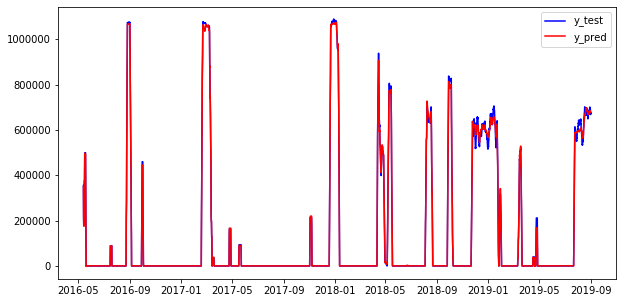

,features,中文,imp
49,MLPAP_FR-0632.PV,汽機風量,0.808947
61,DATA OF USE,觸媒使用時間,0.068018
58,MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,0.033044
31,MLPAP_TJR-0762A1.PV,鹽浴溫度,0.019748
36,MLPAP_TI-0706B01,反應槽觸媒溫度_高度(2865),0.013636


In [9]:
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred,index=X_test.index,name='y_pred')
print(metric(y_test,y_pred,'XGB'))
plot_pred(y_test,y_pred);plt.show()
plot_imp(model).head(5)